# 📡 Kajang Malysian Radar
- Author Hamid ALi Syed
- Date: May 10, 2025
- Purpose: For Alhadi


## 🔧 Environment Setup Instructions

To run this script, you'll need to set up a conda-based environment with the required packages. Follow these steps:

### 1. Install Miniconda
Download and install [Miniconda](https://www.anaconda.com/docs/getting-started/miniconda/install) (or Anaconda, if you prefer).

### 2. Open Terminal or Anaconda Prompt
Once installed, open your preferred terminal (e.g., Anaconda Prompt or system shell).

### 3. Install Micromamba
Micromamba is a lightweight, fast alternative to `conda`.

```bash
conda install micromamba
```

### 4. Create a New Environment
Create an isolated environment named `radar-env`:

```bash
micromamba create -n radar-env
```

### 5. Activate the Environment

```bash
micromamba activate radar-env
```

### 6. Install Required Packages

```bash
micromamba install -c conda-forge radarx xradar arm_pyart nbclassic pandas xarray
```

> ✅ This setup step needs to be done **only once**.

---

## 🚀 Running the Script

Whenever you want to use this script or work with these packages:

1. Open your terminal or shell.
2. Activate the environment:

   ```bash
   micromamba activate radar-env
   ```

3. Launch Jupyter Notebook:

   ```bash
   jupyter-nbclassic
   ```

You’re now ready to run the script inside the notebook environment.

In [1]:
import os
import glob
import pyart
import xradar as xd
import radarx as rx
import xarray as xr
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
files = glob.glob("/Users/syed44/Downloads/RAINBOW/*.vol")
files

['/Users/syed44/Downloads/RAINBOW/2021121812250500dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121812400500dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121812200200dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121812450500dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121812100500dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021110312350500dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121812350500dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121813000200dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121812000300dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121812300500dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121812050500dBZ.vol',
 '/Users/syed44/Downloads/RAINBOW/2021121812500500dBZ.vol']

In [3]:
@xd.map_over_sweeps
def calculate_rain_rate(ds, ref_field="DBZH"):
    def _rain_rate(dbz, a=200.0, b=1.6):
        Z = 10.0 ** (dbz / 10.0)
        return (Z / a) ** (1.0 / b)

    ds = ds.assign(RAIN_RATE=_rain_rate(ds[ref_field]))
    ds.RAIN_RATE.attrs = {"units": "mm/h", "long_name": "Rain Rate"}
    return ds

In [4]:
dss = []
for file in files:
    dtree = xd.io.open_rainbow_datatree(file)
    dtree = dtree.pipe(calculate_rain_rate, ref_field="DBZH")
    ds = dtree['sweep_0'].to_dataset()
    ds['time'] = dtree['sweep_0'].time.min()
    dss.append(ds)

In [6]:
ds = xr.concat(dss, dim='time')

Text(0.5, 1.0, 'QPE')

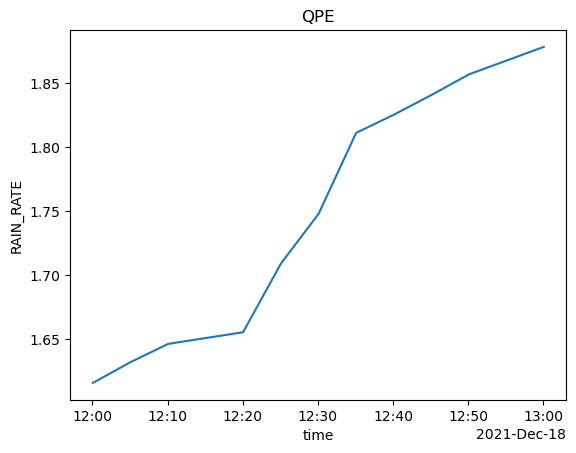

In [8]:
ds.mean(['azimuth', 'range'])['RAIN_RATE'].sortby('time').plot()
plt.title("QPE")

In [9]:
ds = ds.xradar.georeference()

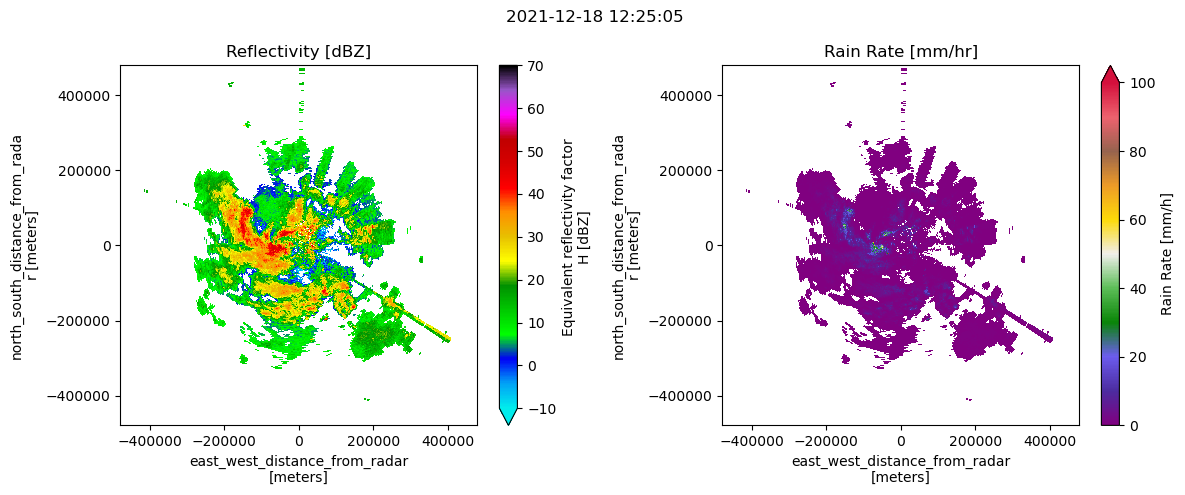

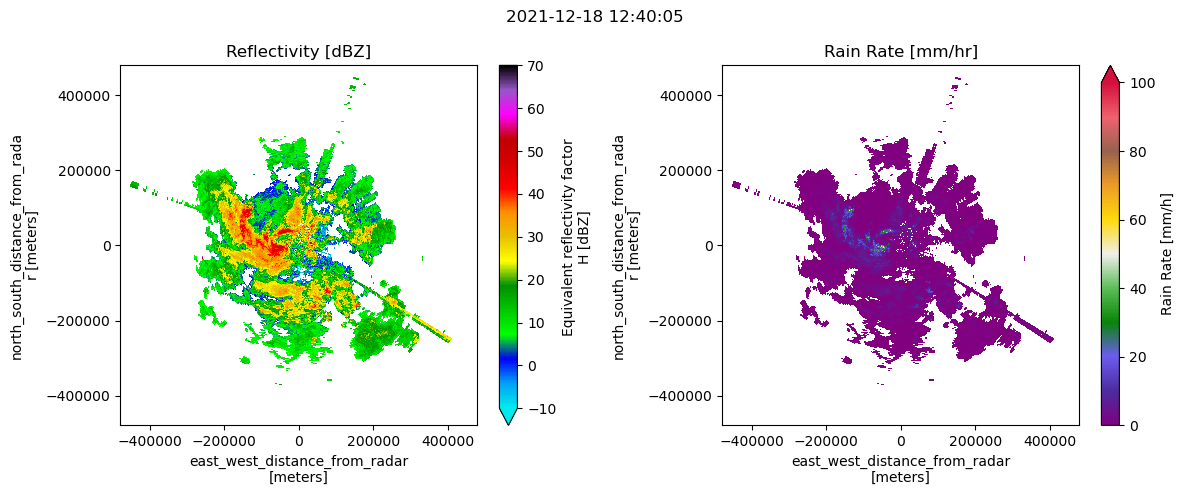

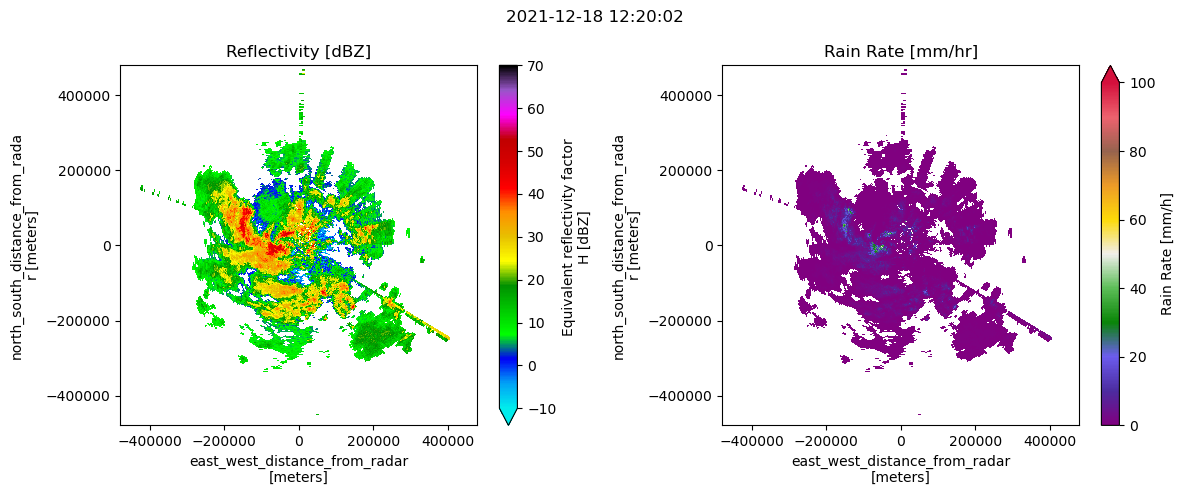

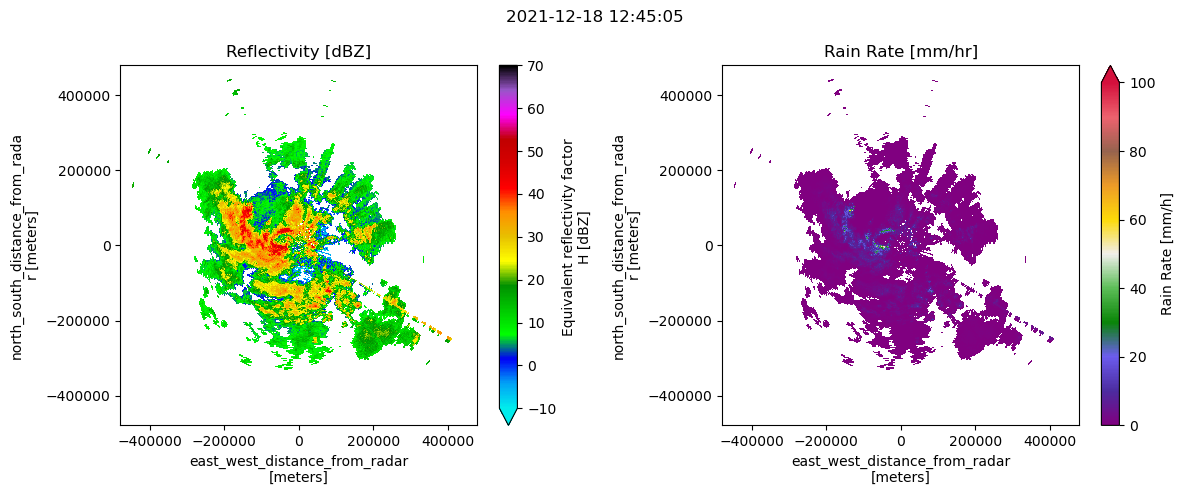

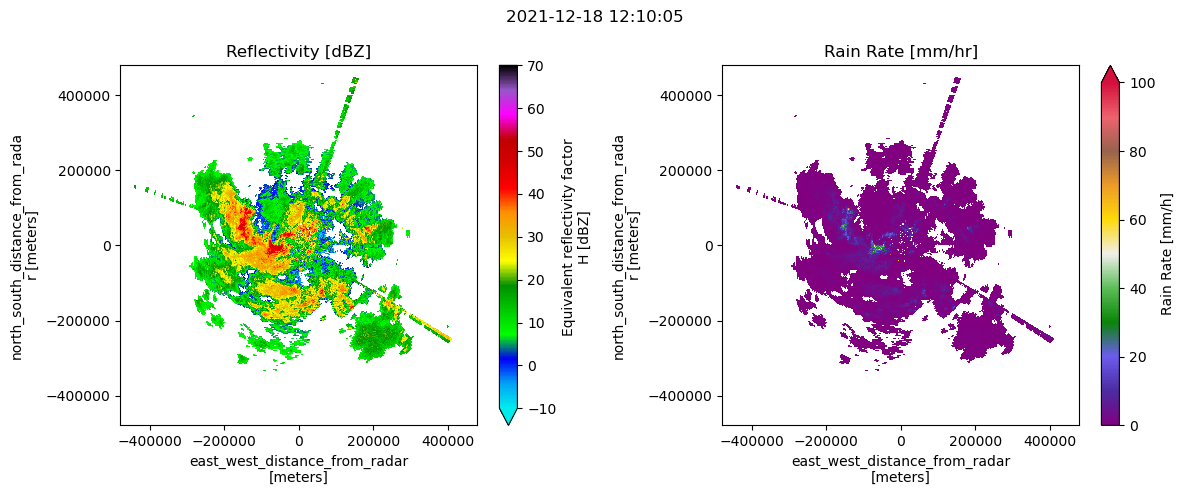

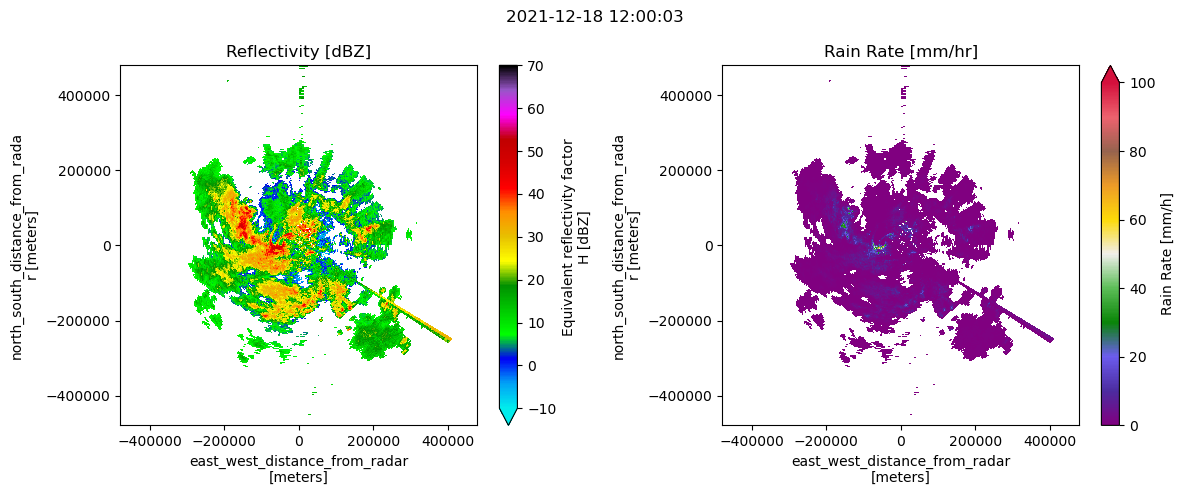

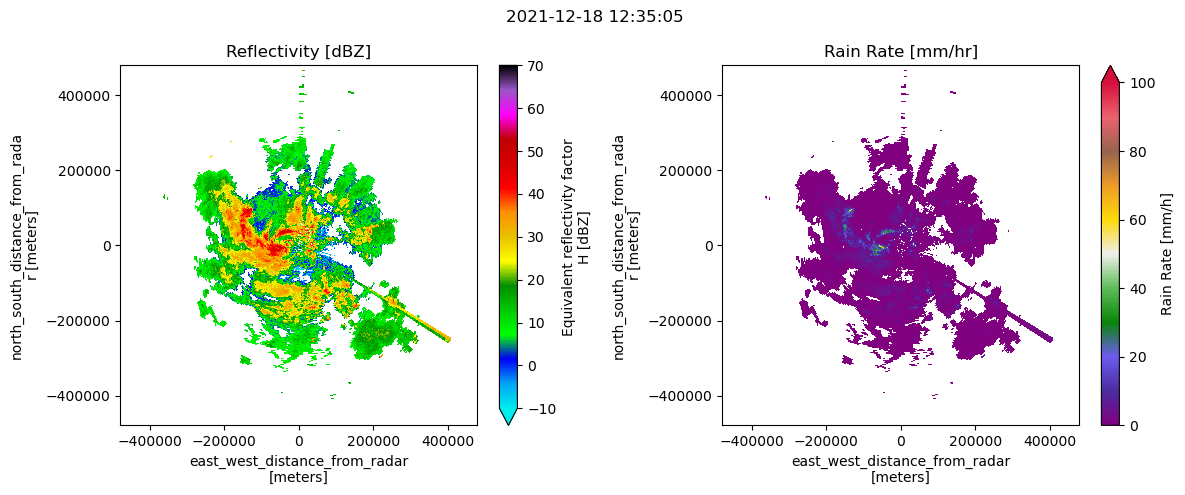

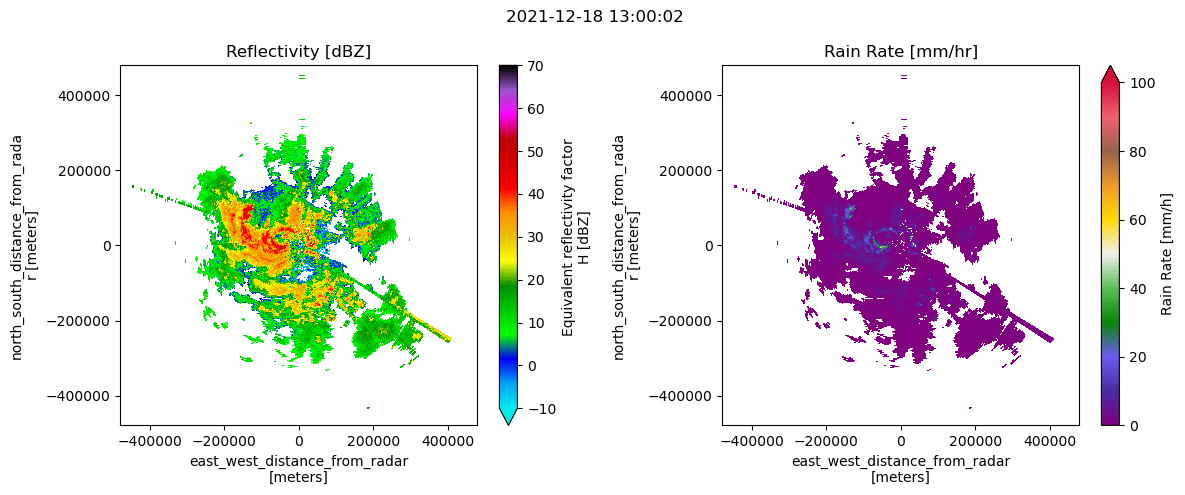

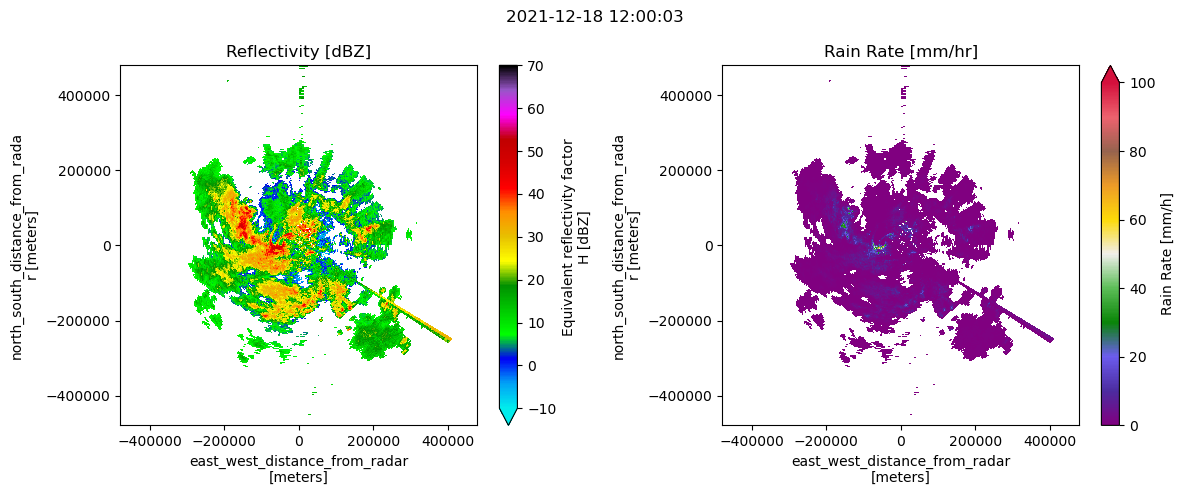

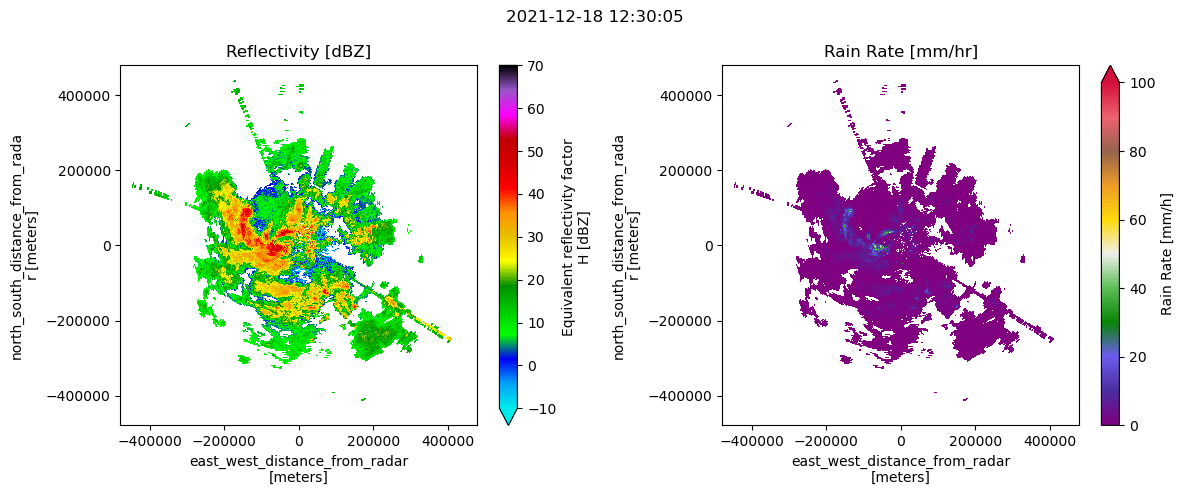

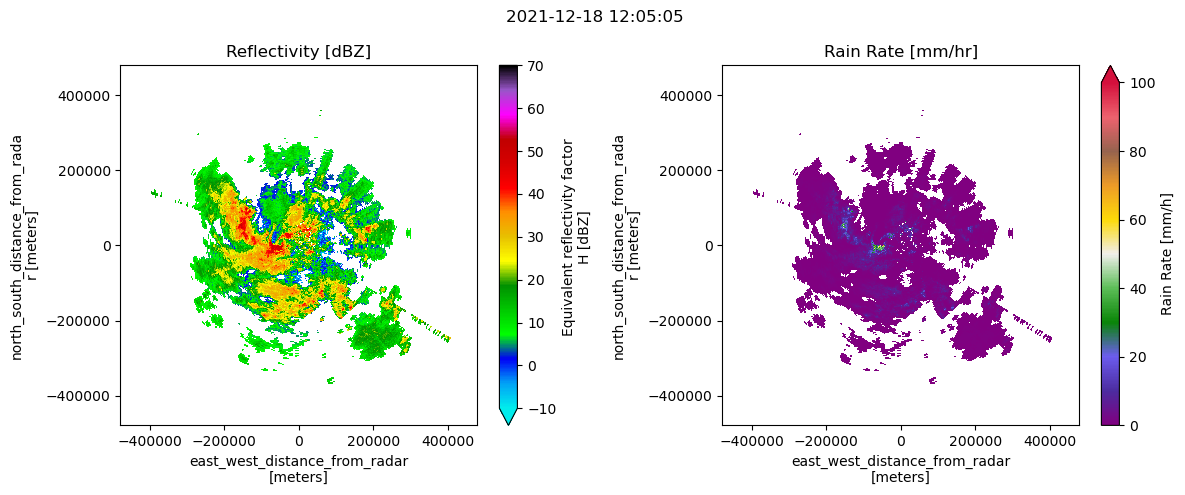

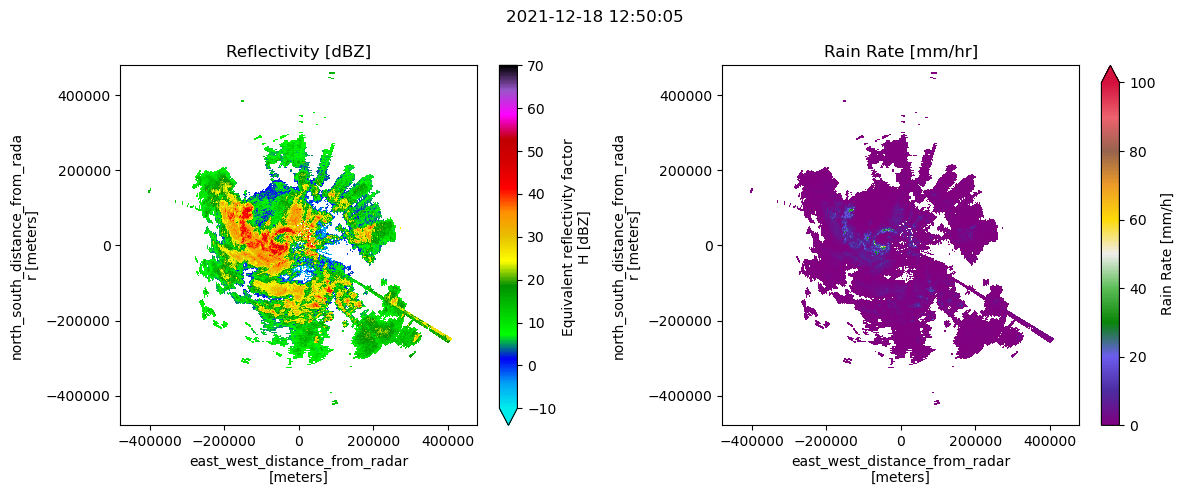

In [24]:
for file in files:
    dtree = xd.io.open_rainbow_datatree(file)
    dtree = dtree.pipe(calculate_rain_rate, ref_field="DBZH")
    dtree = dtree.xradar.georeference()
    ds = dtree['sweep_0'].to_dataset()
    fig, axes = plt.subplots(1, 2, figsize=[12, 5])
    ds['DBZH'].plot(x='x', y='y', ax=axes[0], vmin=-10, vmax=70, cmap='NWSRef')
    axes[0].set_title(f"Reflectivity [dBZ]")
    
    ds['RAIN_RATE'].plot(x='x', y='y', ax=axes[1], vmin=0, vmax=100, cmap='RRate11')
    axes[1].set_title("Rain Rate [mm/hr]")
    plt.suptitle(str(ds.time.min().dt.strftime("%Y-%m-%d %H:%M:%S").values))

    plt.tight_layout()
    plt.show()

In [40]:
lim = 250000.0
grid = dtree.radarx.to_grid(data_vars=['DBZH'],
                            pseudo_cappi=False,
                            x_lim=(-lim, lim),
                            y_lim=(-lim, lim),
                            z_lim=(0, 10000.0),
                            x_step=1000,
                            y_step=1000,
                            z_step=250,
                            x_smth=1,
                            y_smth=1,
                            z_smth=3,)

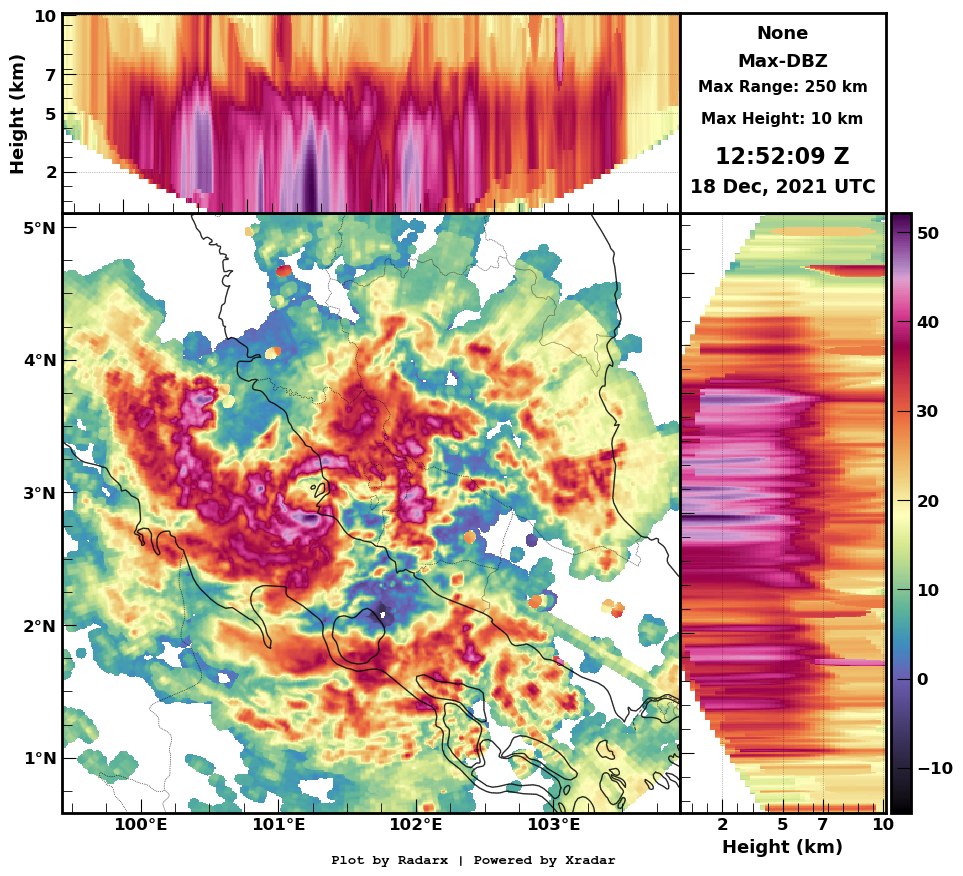

In [41]:
grid.radarx.plot_max_cappi('DBZH', add_slogan=True);

In [42]:
ds

<xarray.Dataset> Size: 14MB
Dimensions:            (azimuth: 360, range: 960)
Coordinates:
    elevation          (azimuth) float64 3kB 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7
  * range              (range) float32 4kB 250.0 750.0 ... 4.792e+05 4.798e+05
    time               (azimuth) datetime64[ns] 3kB 2021-12-18T12:50:16.03125...
    longitude          float64 8B 101.7
    latitude           float64 8B 2.847
    altitude           float64 8B 119.0
  * azimuth            (azimuth) float64 3kB 0.5026 1.522 2.516 ... 358.5 359.5
    crs_wkt            int64 8B 0
    x                  (azimuth, range) float64 3MB 2.193 6.579 ... -4.155e+03
    y                  (azimuth, range) float64 3MB 250.0 749.9 ... 4.789e+05
    z                  (azimuth, range) float64 3MB 122.1 128.2 ... 1.949e+04
Data variables:
    DBZH               (azimuth, range) float64 3MB 28.0 -0.5 nan ... nan nan
    sweep_mode         <U20 80B ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B ...
    RAIN_RATE          (azimuth, range) float64 3MB 2.05 0.03393 nan ... nan nan

You may also find the following example galleries helpful for learning and reference:
1. xradar: https://docs.openradarscience.org/projects/xradar/en/stable/usage.html
2. pyart: https://arm-doe.github.io/pyart/examples/index.html
3. wradlib: https://docs.wradlib.org/en/latest/notebooks/overview.html